# Sunshine List gender analysis

*March 26, 2022*

The gender pay gap is well-researched, and[ validated in Ontario already](https://www.payequity.gov.on.ca/en/LearnMore/GWG/Pages/default.aspx). But what's really missing is an employer-by-employer comparison.

Let's try using the sunshine list to try to compare various public-sector employers in terms of their pay equity. The big problem: we don't have genders of the people on the sunshine list. Here's one way we could solve that problem.

First, we'll import pandas and set a global option to display floats with commas (just to make things more readable). We also use glob and python's regex module here too.

In [280]:
import pandas as pd
import glob         # For importing all our data in a loop.
import re           # Regex module for replacing the values in the year column to correct for an entry error.

pd.options.display.float_format = '{:,.2f}'.format

## 1. Preparing the data

There's a wealth of sunshine list data going back all the way to 2012, so we have a lot of data to pull together into one dataframe. It also needs some cleaning, as some of the files have different column names. There are also some errors in the year column of one file, so to get around that, we get the year from the filename and overwrite the year column with that data instead.

A quick note that we'll also just be looking at salary here, not benefits. Future analysis could sum salaries and benefits, but here I think the more straightforward look at salary is best.

In [281]:
all_files = glob.glob("../raw/genderpaygap/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, encoding="utf-8", encoding_errors='ignore')
    df.columns = df.columns.str.lower()
    df = df.rename(columns={"calendar year": "year", "salary paid": "salary", "taxable benefits": "benefits"})
    df["year"] = int(re.search("[0-9]{4}", filename, re.IGNORECASE).group(0))
    li.append(df)

raw = pd.concat(li, axis=0, ignore_index=True)

raw.sample(5)

,sector,last name,first name,salary,benefits,employer,job title,year,_docid
1366684,School Boards,Hayward,Rachel,"102,766.24",0.00,York Region District School Board,Elementary Teacher,2021,"171,969.00"
591031,Municipalities and Services,Chi,Vivi,"$147,898.27",$443.62,City of Ottawa,"Director, Transportation Planning",2017,NaN
428951,Government of Ontario - Ministries,Coghlin,Matt,"$138,196.22",$137.34,Community Safety and Correctional Services,Law Enforcement Officer,2016,NaN
921196,Municipalities & Services,Wagner,David,"$105,841.35","$1,095.22",County Of Huron,"Superindentent, Emergency Services",2019,NaN
528202,Universities,Tyssen,Michelle,"$102,190.96",$46.80,Université d'Ottawa,Manager,2016,NaN


Now let's do some cleaning. We'll make our column names all lower case for consistency, and we'll make all the strings in our dataset uppercase. This makes it easier to match the names up on joins later in the analysis.

In [282]:
data = raw.copy()

data.columns = data.columns.str.lower()

for label, content in data[["sector", "last name", "first name", "employer", "job title"]].items():
    data[label] = (data[label]
                        .str.upper()
                        .str.replace("\s(AND){1}\s", " & ", regex=True)
                        .str.replace("\-", "–", regex=True)
                        .str.replace("*", "", regex=False)
                )
    
data["salary"] = (data["salary"]
                  .astype(str)
                  .str.replace("\$|,", "", regex=True)
                  .astype(float)
                  )
    
data.sample(5)

,sector,last name,first name,salary,benefits,employer,job title,year,_docid
996197,COLLEGES,WILLIAMS,MARIKKA,"105,729.95",$71.02,SIR SANDFORD FLEMING OF APPLIED ARTS & TECHNOLOGY,"PROFESSOR, SCHOOL OF ENVIRONMENTAL & NATURAL R...",2020,NaN
1238466,HOSPITALS & BOARDS OF PUBLIC HEALTH,CHARTRAND,DAVID,"103,265.21",460.02,SAULT AREA HOSPITAL,REGISTERED NURSE/INFIRMIER AUTORISÉ,2021,"43,751.00"
696146,GOVERNMENT OF ONTARIO – MINISTRIES,DARROCH–DEHENNE,KATHLEEN,"115,833.40",$ 173.50,HEALTH & LONG–TERM CARE,"DIVISIONAL MANAGER, BUSINESS INTEGRATION SERVI...",2018,NaN
1271964,MUNICIPALITIES & SERVICES,CASTRO,LUIS,"101,698.24",411.07,CITY OF MISSISSAUGA,SENIOR INSPECTOR,2021,"77,249.00"
42398,MUNICIPALITIES & SERVICES,GAGNÉ,CHRISTOPHER,"113,568.07",292.35,CITY OF OTTAWA,"COORDINATOR, DATA SERVICES",2012,NaN


Now we're going to read in a dataset of names, downloaded [here](https://data.world/howarder/gender-by-name).

In [283]:
names = pd.read_csv("../raw/RAW 2022 NAME GENDERS.csv")

This dataset has two columns that are important to us: one with a first name, and another with an M or an F, signifying whether it's a male or female name. Now of course this approach is fraught with complications:

1. Some names are common for both men and women. The dataset actually includes a third "probability" column that lists the probability a name is male or female. We don't use it here, but this analysis could be refined by only using names that have a high enough probability.
2. Not everyone identifies as male or female, and using names to identify gender is somewhat outdated. But given that few other approaches exist, we're trying it this way anyways.

Now we're going to make the data in the name field uppercase so we don't have to worry about cases messing up our matching.

In [284]:
names["name"] = names["name"].str.upper()

We're also going to add another column to our dataset for comparing to the names database. We do this because several names in the sunshine list data have initials following the first name (which would not match to a name that would otherwise match). We also have a line of code here that breaks double names (Mary Jane) into just the first part (Mary) so that we don't have to just throw those names out. The assumption is that the first part of the name could probably be used to accurately determine gender.

In [285]:
data["first_name_cleaned"] = (data["first name"]
                              .str.replace("\s+[A-Z]+\.+", "", regex=True)
                              .str.upper()
                              .dropna()
                              .str.split(" ", 1)
                              .dropna().apply(lambda x: x[0])
                              )

By way of example, here's a comparison between the name "IAN D." and what we're using to compare to our names database.

In [286]:
data.loc[data["first name"] == "IAN D.", ["first name", "first_name_cleaned"]].head(3)

,first name,first_name_cleaned
4,IAN D.,IAN
74050,IAN D.,IAN
77571,IAN D.,IAN


Now we merge the names dataset with the sunshine list data. Note we're merging on our newly cleaned first name column. I'm also calling `.loc` to ensure we only include the columns we want, and in an order that I think makes the most sense.

In [287]:
data = (data
        .merge(names, left_on='first_name_cleaned', right_on="name", how="left")
        .drop_duplicates()
        .loc[:, ["year", "first name", "last name", "gender", "sector", "job title", "employer", "salary"]]
        )

We're also going to fill anything that doesn't match with "UNKNOWN".

In [288]:
data["gender"] = data["gender"].fillna("UNKNOWN")

Now let's see what it looks like.

In [289]:
data.sample(5)

,year,first name,last name,gender,sector,job title,employer,salary
226583,2014,TONY,D'ARPINO,M,MUNICIPALITIES & SERVICES,MANAGER CUSTOMER SERVICE BUILDING,CITY OF TORONTO,"107,160.40"
1390950,2021,KATHY,PACIEJKO,F,SCHOOL BOARDS,TEACHER,DUFFERIN–PEEL CATHOLIC DISTRICT SCHOOL BOARD,"103,633.19"
843381,2019,MAUREEN,HELT,F,GOVERNMENT OF ONTARIO – MINISTRIES,"VICE CHAIR, ORDER IN COUNCIL",ATTORNEY GENERAL,"136,077.76"
1422638,2021,ANDRÉ,FORGET,UNKNOWN,UNIVERSITIES,CHEF INGÉNIEUR(E) STATIONNAIRE / CHIEF OPERATI...,UNIVERSITY OF OTTAWA,"123,874.64"
473664,2016,ANGELO,COIRO,M,MUNICIPALITIES & SERVICES,ASSISTANT SUPERVISOR – REVENUE PROCESSING,CITY OF TORONTO – TORONTO TRANSIT COMMISSION,"100,100.20"


Now that our dataset is prepared, we can dive into the good stuff.

## 2. The 2021 sunshine list

### Mean salary by sector

Beceause the sunshine list is everyone who makes more than $100K annually, we can find out a lot here by just checking out the counts of men and women on the list. Let's start with that.

In [290]:
gender_counts = data.loc[data["year"] == 2021, ["gender", "first name"]].groupby("gender").count()

gender_counts

,first name
gender,
F,121163
M,105807
UNKNOWN,17420


There are actually more women than men on our list!

It's also useful to see how many names on our list have been labeled with a gender (versus just labelled Unknown, which is what we relabelled our null values). Of course, we should do some manually spot checking to see how accurate we think the name gendering was, but this will give us a sense of how many values were mapped to something in the dataset.

In [291]:
(gender_counts.loc["F", :] + gender_counts.loc["M", :]) / gender_counts.sum() * 100

first name   92.87
dtype: float64

Roughly 92% of names in the sunshine list were assigned a gender from the names list! Not bad. Now, back to our analysis. Let's see the counts by sector.

In [292]:
(data[data["year"] == 2021]
 .pivot_table(index="sector", values="salary", columns="gender", aggfunc="count")
 .sort_values("F", ascending=False)
 )

gender,F,M,UNKNOWN
sector,,,
SCHOOL BOARDS,"53,392.00","22,770.00","4,272.00"
HOSPITALS & BOARDS OF PUBLIC HEALTH,"21,351.00","6,314.00","2,906.00"
MUNICIPALITIES & SERVICES,"14,000.00","36,528.00","3,307.00"
UNIVERSITIES,"9,190.00","10,919.00","2,987.00"
GOVERNMENT OF ONTARIO – MINISTRIES,"7,991.00","10,991.00","1,337.00"
OTHER PUBLIC SECTOR EMPLOYERS,"5,080.00","3,020.00",631.00
CROWN AGENCIES,"4,450.00","4,490.00",884.00
COLLEGES,"3,637.00","3,790.00",437.00
ONTARIO POWER GENERATION,"1,490.00","6,440.00",590.00


There are far more women than men on the list in the school, hospital, and municipalities sectors.

Before we continue, let's remove the seconded sectors here, as they don't seem that interesting and we want to keep our tables readable here.

In [293]:
data_noseconded = data[~data["sector"].str.contains("SECONDED")]

Now, we'll take a look at the mean salaries for each sector.

In [294]:
(data_noseconded[data_noseconded["year"] == 2021]
 .pivot_table(index="sector", values="salary", columns="gender", aggfunc="mean")
 .dropna()
 .rename(columns={"salary": "gendered"})
 )

gender,F,M,UNKNOWN
sector,,,
COLLEGES,"119,965.02","119,909.56","116,069.26"
CROWN AGENCIES,"128,613.06","135,230.03","126,394.56"
GOVERNMENT OF ONTARIO – JUDICIARY,"239,394.48","243,610.83","209,683.97"
GOVERNMENT OF ONTARIO – LEGISLATIVE ASSEMBLY & OFFICES,"138,690.75","138,861.28","132,769.40"
GOVERNMENT OF ONTARIO – MINISTRIES,"130,026.95","130,673.86","123,632.89"
HOSPITALS & BOARDS OF PUBLIC HEALTH,"119,190.00","134,527.42","125,276.92"
MUNICIPALITIES & SERVICES,"122,733.62","125,364.40","121,554.09"
ONTARIO POWER GENERATION,"145,029.68","155,543.36","149,466.83"
OTHER PUBLIC SECTOR EMPLOYERS,"129,350.55","140,225.40","131,233.50"


And the median salary too, to get a sense of the average values without the big outliers influencing things.

In [295]:
(data_noseconded[data_noseconded["year"] == 2021]
 .pivot_table(index="sector", values="salary", columns="gender", aggfunc="median")
 .dropna()
 .rename(columns={"salary": "gendered"})
 )

gender,F,M,UNKNOWN
sector,,,
COLLEGES,"115,378.12","115,378.12","115,354.01"
CROWN AGENCIES,"115,918.25","120,310.04","116,419.38"
GOVERNMENT OF ONTARIO – JUDICIARY,"159,266.54","267,013.37","154,173.92"
GOVERNMENT OF ONTARIO – LEGISLATIVE ASSEMBLY & OFFICES,"128,859.79","129,517.58","126,242.05"
GOVERNMENT OF ONTARIO – MINISTRIES,"115,786.98","119,338.34","114,129.41"
HOSPITALS & BOARDS OF PUBLIC HEALTH,"109,873.87","114,076.31","110,821.33"
MUNICIPALITIES & SERVICES,"115,780.48","119,933.02","115,544.70"
ONTARIO POWER GENERATION,"133,665.06","144,675.01","139,950.98"
OTHER PUBLIC SECTOR EMPLOYERS,"117,454.21","122,479.24","115,951.20"


### Mean salary by employer

Now let's break things down by employer instead. The analysis is similar to above.

In [296]:
employers = (data[data["year"] == 2021]
 .pivot_table(index="employer", values="salary", columns="gender", aggfunc="count")
 .dropna()
 .rename(columns={"salary": "gendered"})
 .sort_values("M", ascending=False)
 )

employers

gender,F,M,UNKNOWN
employer,,,
ONTARIO POWER GENERATION,"1,477.00","6,341.00",583.00
CITY OF TORONTO,"2,059.00","4,716.00",570.00
ONTARIO PROVINCIAL POLICE,"1,331.00","3,924.00",120.00
CITY OF TORONTO – POLICE SERVICE,"1,004.00","3,661.00",360.00
TORONTO DISTRICT SCHOOL BOARD,"6,595.00","3,111.00",843.00
...,...,...,...
CHILDREN’S AID SOCIETY OF THE UNITED COUNTIES OF STORMONT DUNDAS & GLENGARRY,18.00,1.00,2.00
SUDBURY DISTRICT NURSE PRACTITIONER CLINICS,5.00,1.00,1.00
ONTARIO PAROLE BOARD,2.00,1.00,1.00


Because some employers only have a handful of employees listed on the sunshine list, we're also going to exclude orgs with fewer than 100 employees that have been identified by our analysis as male or female. We start by getting a list of those orgs.

In [297]:
employers["total_gendered"] = employers["M"] + employers["F"]
employers["%_unknown"] = round(employers["total_gendered"] / (employers["UNKNOWN"] + employers["total_gendered"])* 100, 2)

included_orgs = employers[employers["total_gendered"].gt(300)].index

Then we use the list to filter the data before we pivot to find mean salaries.

In [298]:
employer_mean = (data
.loc[(data["employer"].isin(included_orgs)) & (data["year"] == 2021), :]
.pivot_table(index="employer", values="salary", columns="gender", aggfunc="mean")
)

employer_mean.head(5)

gender,F,M,UNKNOWN
employer,,,
ALGOMA DISTRICT SCHOOL BOARD,"107,740.80","110,466.52","107,627.53"
ALGONQUIN & LAKESHORE CATHOLIC DISTRICT SCHOOL BOARD,"107,644.35","110,302.79","109,060.36"
ALGONQUIN COLLEGE OF APPLIED ARTS & TECHNOLOGY,"119,323.42","117,602.71","111,351.31"
ATTORNEY GENERAL,"173,546.32","185,128.43","161,273.08"
AVON MAITLAND DISTRICT SCHOOL BOARD,"106,496.67","108,493.00","107,134.05"


Like we did for sectors, I'd also like to take a look at the medians.

In [299]:
employer_median = (data[data["year"] == 2021]
.loc[data["employer"].isin(included_orgs), :]
.pivot_table(index="employer", values="salary", columns="gender", aggfunc="median")
)

employer_median

gender,F,M,UNKNOWN
employer,,,
ALGOMA DISTRICT SCHOOL BOARD,"104,197.53","105,133.29","104,077.26"
ALGONQUIN & LAKESHORE CATHOLIC DISTRICT SCHOOL BOARD,"102,378.66","102,378.66","102,378.66"
ALGONQUIN COLLEGE OF APPLIED ARTS & TECHNOLOGY,"115,378.12","115,378.12","114,423.76"
ATTORNEY GENERAL,"168,669.26","204,178.89","150,945.82"
AVON MAITLAND DISTRICT SCHOOL BOARD,"102,536.84","104,147.08","103,952.34"
...,...,...,...
WINDSOR–ESSEX CATHOLIC DISTRICT SCHOOL BOARD,"104,110.26","104,247.35","104,247.35"
WORKPLACE SAFETY & INSURANCE BOARD,"105,651.92","109,481.34","110,887.32"
YORK CATHOLIC DISTRICT SCHOOL BOARD,"102,567.74","103,420.26","102,567.74"


This time, let's also add another column to calculate the difference between the average salary for men and for women, then sort by that category.

In [300]:
employer_mean["diff"] = employer_mean["M"] - employer_mean["F"]

employer_mean.sort_values("diff", ascending=False).head()

gender,F,M,UNKNOWN,diff
employer,,,,
THE HOSPITAL FOR SICK CHILDREN,"134,284.06","180,429.21","164,793.81","46,145.15"
SINAI HEALTH SYSTEM,"125,670.21","165,115.67","133,840.94","39,445.46"
GRAND RIVER HOSPITAL CORPORATION,"117,412.26","145,795.58","131,944.49","28,383.32"
HAMILTON HEALTH SCIENCES,"118,083.10","139,944.89","129,008.84","21,861.79"
MCMASTER UNIVERSITY,"155,117.47","176,453.54","169,481.96","21,336.07"


Doing the same for our median table...

In [301]:
employer_median["diff"] = employer_median["M"] - employer_median["F"]

employer_median.sort_values("diff", ascending=False).head()

gender,F,M,UNKNOWN,diff
employer,,,,
ONTARIO COURT OF JUSTICE,"159,266.54","254,624.21","154,173.92","95,357.67"
ATTORNEY GENERAL,"168,669.26","204,178.89","150,945.82","35,509.63"
MCMASTER UNIVERSITY,"143,979.44","173,877.52","167,128.59","29,898.08"
UNIVERSITY OF WATERLOO,"136,354.16","160,363.21","163,994.68","24,009.05"
THE HOSPITAL FOR SICK CHILDREN,"112,662.99","132,216.00","120,148.52","19,553.01"


## 3. What does the gender pay gap look like year over year?

Why didn't we use data from all years together when looking at pay gap in various sectors and employers? There are two reasons:

1. It's hard to compare money over the course of many years. $120K in 2012 is different than $120K in 2021.
2. There are likely many duplicate names that are very hard to remove from our dataset if we combine them all. For example, some of the top earners on the sunshine list are there in many years. We don't want to count these outliers more than once, as it might skew our data.

So for the employer analysis, we focus on just the new data. But one way we can kind of get around comparing year by year is to just look at the % difference between men and women for each year, and compare those over time. Let's start by looking at the number of men vs. the number of women on the list going back to 2012 before we get into salary comparisons.

<AxesSubplot:xlabel='year'>

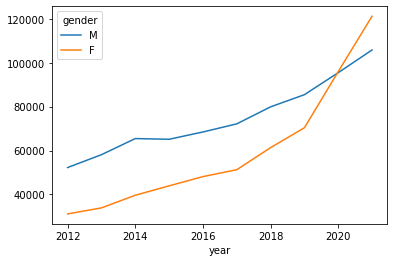

In [302]:
annual_counts = (data
              .pivot_table(columns="gender", index="year", values="salary", aggfunc="count")
              )

annual_counts[["M", "F"]].plot()

The number of women on the list has been increasing year over year. 2021 was really the first year that women overtook men, while in 2020 they were roughly equal. Now let's do something similar but looking at the mean salaries rather than the counts.

<AxesSubplot:xlabel='year'>

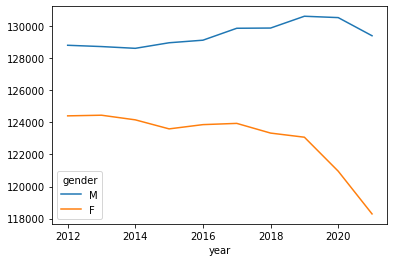

In [303]:
annual_gap = (data
              .loc[data["gender"].isin(["M", "F"]),:]
              .pivot_table(columns="gender", index="year", values="salary", aggfunc="mean")
              )

annual_gap[["M", "F"]].plot()

We can see that average pay has largely been decreasing as a whole over the last few years for both genders, but that the curve for women is steeper.

Let's calculate a new column with how much more the men make on average that year across all sectors to see the more direct impact on the pay gap.

In [304]:
annual_gap["difference"] = ((annual_gap["M"] - annual_gap["F"]) / annual_gap["M"]) * 100

annual_gap

gender,F,M,difference
year,,,
2012,"124,408.63","128,810.84",3.42
2013,"124,449.15","128,730.28",3.33
2014,"124,160.31","128,620.33",3.47
2015,"123,596.54","128,967.64",4.16
2016,"123,862.08","129,127.53",4.08
2017,"123,939.36","129,871.49",4.57
2018,"123,334.83","129,885.00",5.04
2019,"123,077.27","130,621.21",5.78
2020,"120,958.67","130,536.40",7.34


...and plot it so we can see it more clearly.

<AxesSubplot:xlabel='year'>

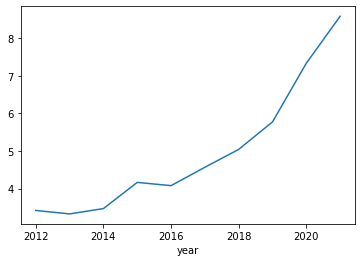

In [305]:
annual_gap["difference"].plot()

According to this analysis, the pay gap has gotten steadily more pronounced!

## 4. What can we conclude?

As mentioned before, this analysis comes with a load of caveats, and probably shouldn't be interpreted as 100% truth. It's one way to get some insight into the gender pay gap in public sector Ontario, where we have very little information.

\-30\-